In [1397]:
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
import statistics as st
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.distributions.empirical_distribution import ECDF
from TimeSerie_fct import create_monthly_avg_time_serie
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import calendar
import os


data_temperature = pd.read_table('../data/observatoire-geneve/TG_STAID000241.txt',sep = ',',
                                names = ['SOUID','DATE','TG','Q_TG'], skiprows = range(0,20))

data_temperature.drop(data_temperature[ data_temperature['Q_TG'] == 9 ].index, inplace = True)
data_temperature['Year'] = [int(str(d)[:4]) for d in data_temperature.DATE]
data_temperature['Month'] = [int(str(d)[4:6]) for d in data_temperature.DATE]
data_temperature['Day'] = [int(str(d)[6:8]) for d in data_temperature.DATE]

#Compute the day of the year for each year
day_of_year = np.array(len(data_temperature['Day']))

adate = [datetime.strptime(str(date),"%Y%m%d") for date in data_temperature.DATE]
data_temperature['Day_of_year'] = [d.timetuple().tm_yday for d in adate]
data_temperature.TG = data_temperature.TG/10.

In [1398]:
df = data_temperature.copy()
plt.style.use("ggplot")
plt.style.use("seaborn")


In [1399]:
# Transformation en moyenne mesuelle
Years = df.Year.unique()
Months = df.Month.unique()
data_M = pd.DataFrame(np.array([[df[(df.Year == y)&(df.Month==m)].TG.mean(),
                        df[(df.Year == y)&(df.Month==m)].TG.median(),df[(df.Year == y)&(df.Month==m)].TG.std()
                                 ,y,int(m)] for y in Years for m in Months]),
                     columns=["Mean","Median","Std","Years","Month"])
data_M = data_M.dropna()
data_M["grid"] = np.array([y + float(m-1)/12 for y in Years for m in Months])[:np.shape(data_M)[0]]

data_M["Date"] = [(str(int(y))+str('-')+str(int(m))) for y in Years for m in
                  data_M[data_M.Years == y].Month]

for j in range(np.shape(data_M.Mean)[0]):
    if (data_M.Month[j]<10.):
        data_M.loc[j,"Date"] = data_M.Date[j][:5]+str('0')+str(int(data_M.Month[j]))

In [1400]:
data_M.to_csv("DataGenerated/Monthly/Monthly_Mean.csv",index=False)


In [1401]:
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8),(ax9,ax10),(ax11,ax12)) = plt.subplots(6,2,figsize=(18,12))
axs = (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12)
fig.suptitle("Evolution of the mean temperature by month",y = 0.95,size='xx-large',weight = 'roman')
for m in Months:
    Y = data_M[data_M.Month == m].Years.unique()
    axs[m-1].plot(Y,data_M[data_M.Month==m].Mean, color = 'k')
    axs[m-1].set_title(calendar.month_name[int(m)])
    plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.8)

    axs[m-1].set_xlabel("Years")
    axs[m-1].set_ylabel("Temperature(°C)",fontsize=8)

plt.savefig("figure/Monthly/Monthly_mean_median_std.png", dpi=300, bbox_inches='tight')
plt.close(fig)

In [1402]:
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8),(ax9,ax10),(ax11,ax12)) = plt.subplots(6,2,figsize=(18,12))
axs = (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12)
fig.suptitle("Anomalie of the mean temperature by month",y = 0.95,size='xx-large',weight = 'roman')
for m in Months:
    Y = data_M[data_M.Month == m].Years.unique()
    mean = data_M[data_M.Month==m].Mean.mean()
    anomalie = (data_M[data_M.Month==m].Mean-mean)/(data_M[data_M.Month==m].Mean-mean).std()
    axs[m-1].bar(Y,anomalie, color = 'k')
    axs[m-1].set_title(calendar.month_name[int(m)])
    plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.8)

    axs[m-1].set_xlabel("Years")
    axs[m-1].set_ylabel("Temperature(°C)",fontsize=8)

plt.savefig("figure/Monthly/Monthly_anomalie.png", dpi=300, bbox_inches='tight')
plt.close(fig)

In [1403]:
fig, ax = plt.subplots(1,1,figsize=(30,4), dpi= 300)
fig.suptitle("Monthly mean temperature",y = 1.,size='x-large',weight = 'roman')
plt.plot(data_M.grid,data_M.Mean)
ax.set(xlabel="Years",ylabel="Temperature(°C)")
plt.savefig("figure/Monthly_mean_TimeSeries.png", dpi=300, bbox_inches='tight')
plt.close(fig)

# Fit on all the time series

In [1404]:
def ff(m,y,param):
    tg = 0
    for i in range(1,13):
        tg += (m==float(i))*param[i-1]
    tg += param[-1]*y
    return tg

In [1405]:
def plot_ljung_pierce(data, loca = (0.82,0.7), semilog_y = True,fname ='figure/p_values_Ljung_Pierce_McLeod_test.png', closefig = False,alpha = 0.05,df=0):
    test_Q = sm.stats.acorr_ljungbox(data, lags=range(1,50), return_df=True,boxpierce=True,model_df = df)

    p_values_McLeod_Li = sm.stats.acorr_ljungbox(data**2, lags=range(1,50), return_df=True,model_df = df).lb_pvalue
    p_values_Pierce = test_Q.lb_pvalue
    p_values_Ljung = test_Q.bp_pvalue
    
    fig = plt.figure(figsize=(9,5), dpi=300, tight_layout = True)
    fig.suptitle("P-values of the Ljung-Box ,Box-Pierce and McLeod-Li Tests",y = 0.95
                 ,size='x-large',weight = 'roman')


    plt.plot(p_values_Pierce,'o-',markersize = 4,label='Box-Pierce')
    plt.plot(p_values_Ljung,'-o',markersize = 4,label='Ljung-Box')
    plt.plot(p_values_McLeod_Li,'-o',markersize = 4,label='McLeod-Li')
    
    if (semilog_y): plt.semilogy()
    plt.axhline(y=alpha,linestyle='--',label='p_value = '+str(alpha))
    fig.legend(loc = loca)
    plt.xlabel('Autocorrelation lags')
    plt.ylabel('p-values')

    plt.savefig(fname, dpi=300, bbox_inches='tight')
    if (closefig) : plt.close(fig)
    return 

In [1406]:
def plot_acf_pacf(data,lag = 50,closefig=False,fname = "figure/Annual_acf_pacf_test.png",title = 'ACF and PACF'):
    fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 300)
    
    fig.suptitle(title,y = 1.1,size='x-large',weight = 'roman')
    
    plot_acf(data, lags=lag,ax=axes[0], color='k',zero = False,auto_ylims = True)
    plot_pacf(data, lags=lag,ax=axes[1], color='k',zero = False,auto_ylims = True,method = 'ywm')
    
    axes[0].set(xlabel="lags")
    axes[1].set(xlabel="lags")
    
    
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    if (closefig): plt.close(fig)
    return

In [1407]:
def qq_plot(data,fname = "figure/Annual_qqplot_test.png"):
    fig = qqplot(data,loc = data.mean(), scale = data.std(), line ='45')
    fig.suptitle("QQ-plot",y = 0.95,size='xx-large',weight = 'roman')
    plt.show()
    
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.close(fig)
    return

In [1408]:
def ecdf_vs_cdf(data,fname ="figure/Annual_ecdf_cdf_test.png", closefig=False):
    ecdf = ECDF(data)
    mean = data.mean()
    std = data.std()
    x = np.linspace(-4.+mean,4.+mean,5000)
    
    fig, axs = plt.subplots(1,2, figsize=(14,4))
    
    axs[0].plot(x,ecdf(x),"k",label='ecdf')
    axs[0].plot(x,sc.stats.norm.cdf(x,loc = mean,scale = std), "b--", label = 'cdf')
    axs[1].plot(x,np.abs(ecdf(x)-sc.stats.norm.cdf(x,loc = mean ,scale = std)),color = 'k')
    
    axs[0].set(xlabel="x",ylabel="P (X<=x)")
    axs[1].set(xlabel="x",ylabel="Absolute deviation")
    axs[0].set_title("Ecdf vs cdf")
    axs[1].set_title("Absolute deviation of the ecdf from the cdf")
    
    axs[0].legend(loc = (0.05,0.8))
    
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    if (closefig): plt.close(fig)
    return

## Modélisation  1

In [1451]:
# We make a pilot estimate of the covariance matrix

STL_fit = STL(data_M.Mean,period=12).fit()
res = STL_fit.resid

test_addfuller = adfuller(res, maxlag=None, regression='n', autolag='AIC'
                          , store=False, regresults=True)


sigma_estimate = res.var()*sc.linalg.toeplitz(acf(res,nlags=n,fft=False))
#test_addfuller[1]

In [1452]:
# Temperature explain by the years and a intercept depending on the month
tol_conv = 1e-010
n = np.shape(data_M.Mean)[0]
t = np.array(data_M.Mean).reshape((n,1))
one = np.ones(shape=(np.shape(t)[0],1))
d = np.concatenate([np.array([(data_M.Month == float(i))]).reshape((n,1)) for i in np.arange(1,13)],axis = 1)
d2 = data_M.Years.copy()-1900

D2 = np.array(d2).reshape((n,1))
X = np.concatenate([d,D2],axis = 1)

sigma = sigma_estimate  #data_Y.Mean not stationary so we cannot use acf on it 
sigma_prec = np.eye(n)
reg = sm.GLS(data_M.Mean,X,sigma).fit()
res = reg.resid

#We test the stationarity for use the acf
test_addfuller = adfuller(res, maxlag=None, regression='n', autolag='AIC'
                          , store=False, regresults=True)
iter_stationarity_bool_ = np.array([bool(test_addfuller[1]<0.05)])

while (np.linalg.norm(sigma-sigma_prec)>tol_conv):
    test_addfuller = adfuller(res, maxlag=None, regression='n', autolag='AIC',store=False, regresults=True)
    iter_stationarity_bool_ = np.concatenate([iter_stationarity_bool_,np.array([bool(test_addfuller[1]<0.05)])])
    acf_ = acf(res,nlags=n,fft=False)
    sigma_prec = sigma
    sigma = res.var()*sc.linalg.toeplitz(acf_)
    reg = sm.GLS(data_M.Mean,X,sigma).fit()
    res = reg.resid


coef = reg.params
#print(reg.summary())

In [1453]:
print(iter_stationarity_bool_)

monthly_seasonless_gls = pd.DataFrame()
monthly_seasonless_gls["Date"] = data_M.Date
monthly_seasonless_gls["resid"] = res
monthly_seasonless_gls["f"] = data_M.Mean - res
monthly_seasonless_gls.to_csv("DataGenerated/Monthly/Monthly_Seasonless.csv",index=False)

reg.pvalues

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]


x1      1.642055e-03
x2      1.085959e-18
x3     1.210724e-132
x4     2.966960e-289
x5      0.000000e+00
x6      0.000000e+00
x7      0.000000e+00
x8      0.000000e+00
x9      0.000000e+00
x10     0.000000e+00
x11    5.633726e-116
x12     1.898819e-17
x13     4.327646e-04
dtype: float64

In [1454]:
summary1 = reg.summary()
g = open('DataGenerated/Monthly/summary1_GLS','w')
g.write(summary1.as_html())
g.close()
# F-stat big / good R-squared / positive conf. int. for the linear term in year (x13) 

In [1455]:
#Plot entiere regression
fig = plt.figure(figsize=(25,5), dpi=300, tight_layout = True)
fig.suptitle("Residus after modelisation of the trend and seasonality by GLS",y = 0.95,size='x-large',weight = 'roman')

plt.plot(data_M.grid,res,'grey')

plt.xlabel('Year')
plt.ylabel('Residus(°C)')

plt.savefig('figure/Monthly/GLS1_res.png', dpi=300, bbox_inches='tight')
plt.close()

In [1456]:
data_M["Mean_Seasonless"] = res

In [1457]:
#Stationarity test on seasonless mean with addfuller
test_addfuller = adfuller(data_M.Mean_Seasonless, maxlag=None, regression='n', autolag='AIC'
                          , store=False, regresults=True)

g = open('txt/Monthly/addfullerTest_monthly1.txt','a')
g.write("Monthly Seasonless mean (no constant) (model 1) : p-value = "+str(test_addfuller[1])+'\n')
g.close()
test_addfuller[1]
# the p-value of the addfuller test let us think that the time series is stationary

4.231132821210104e-05

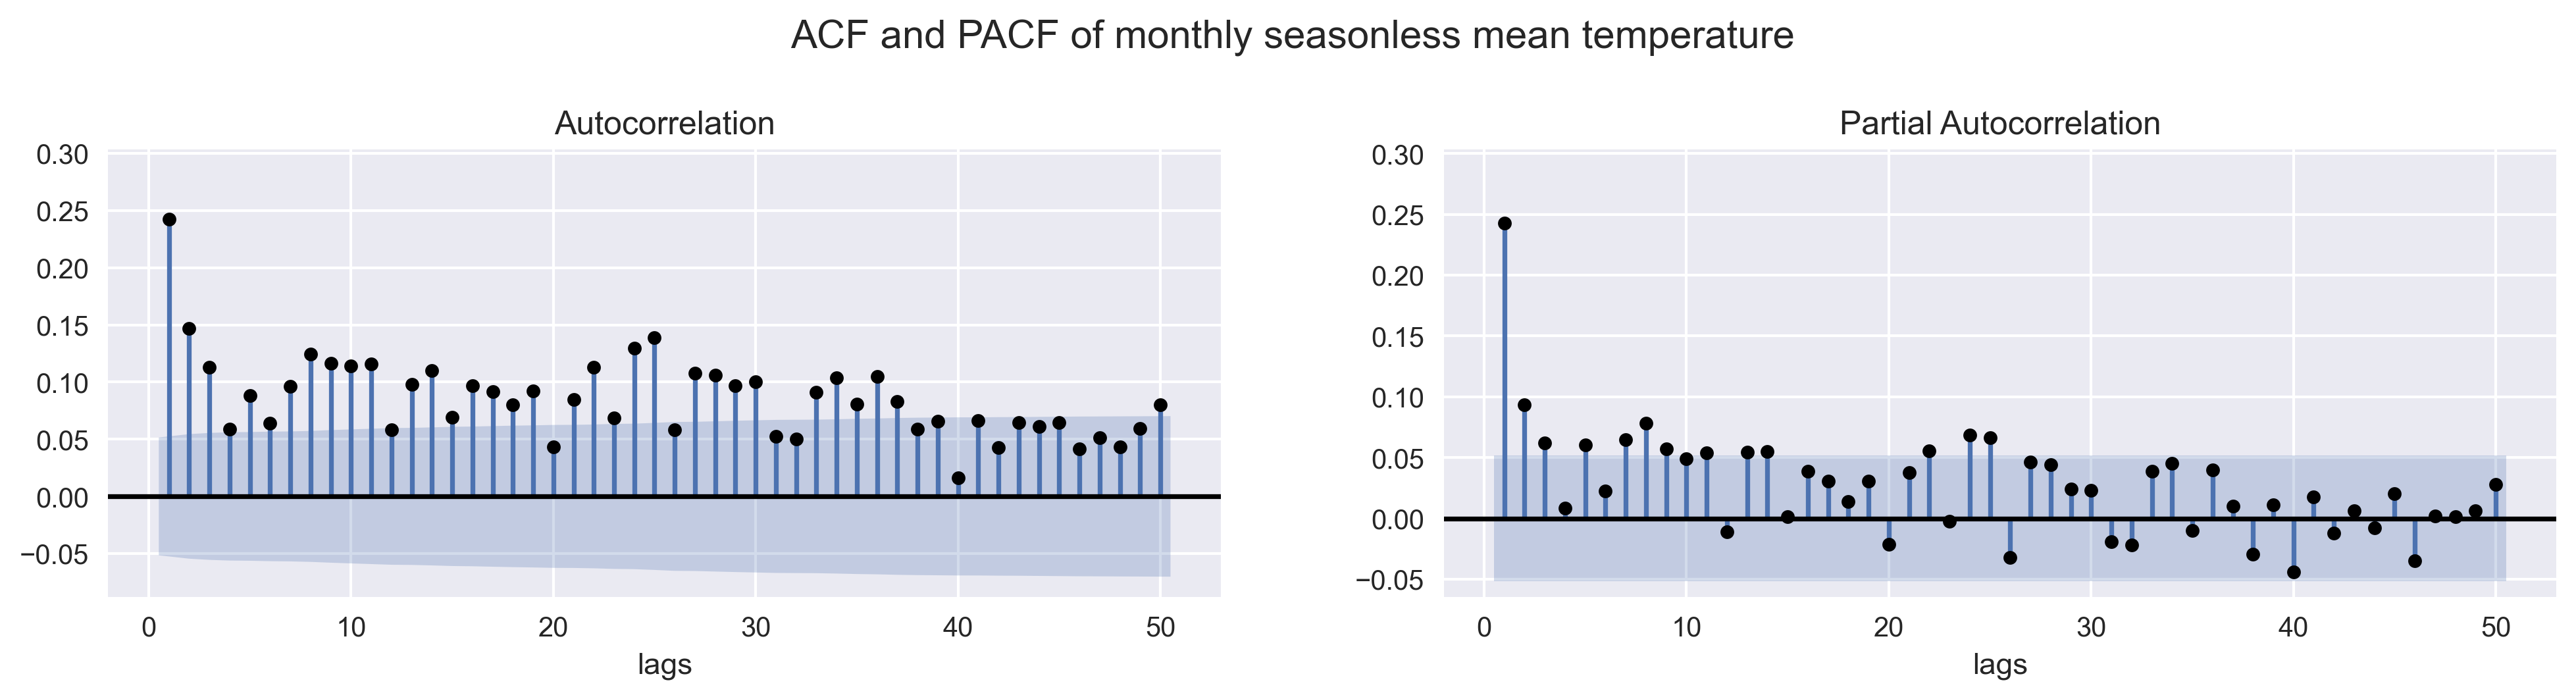

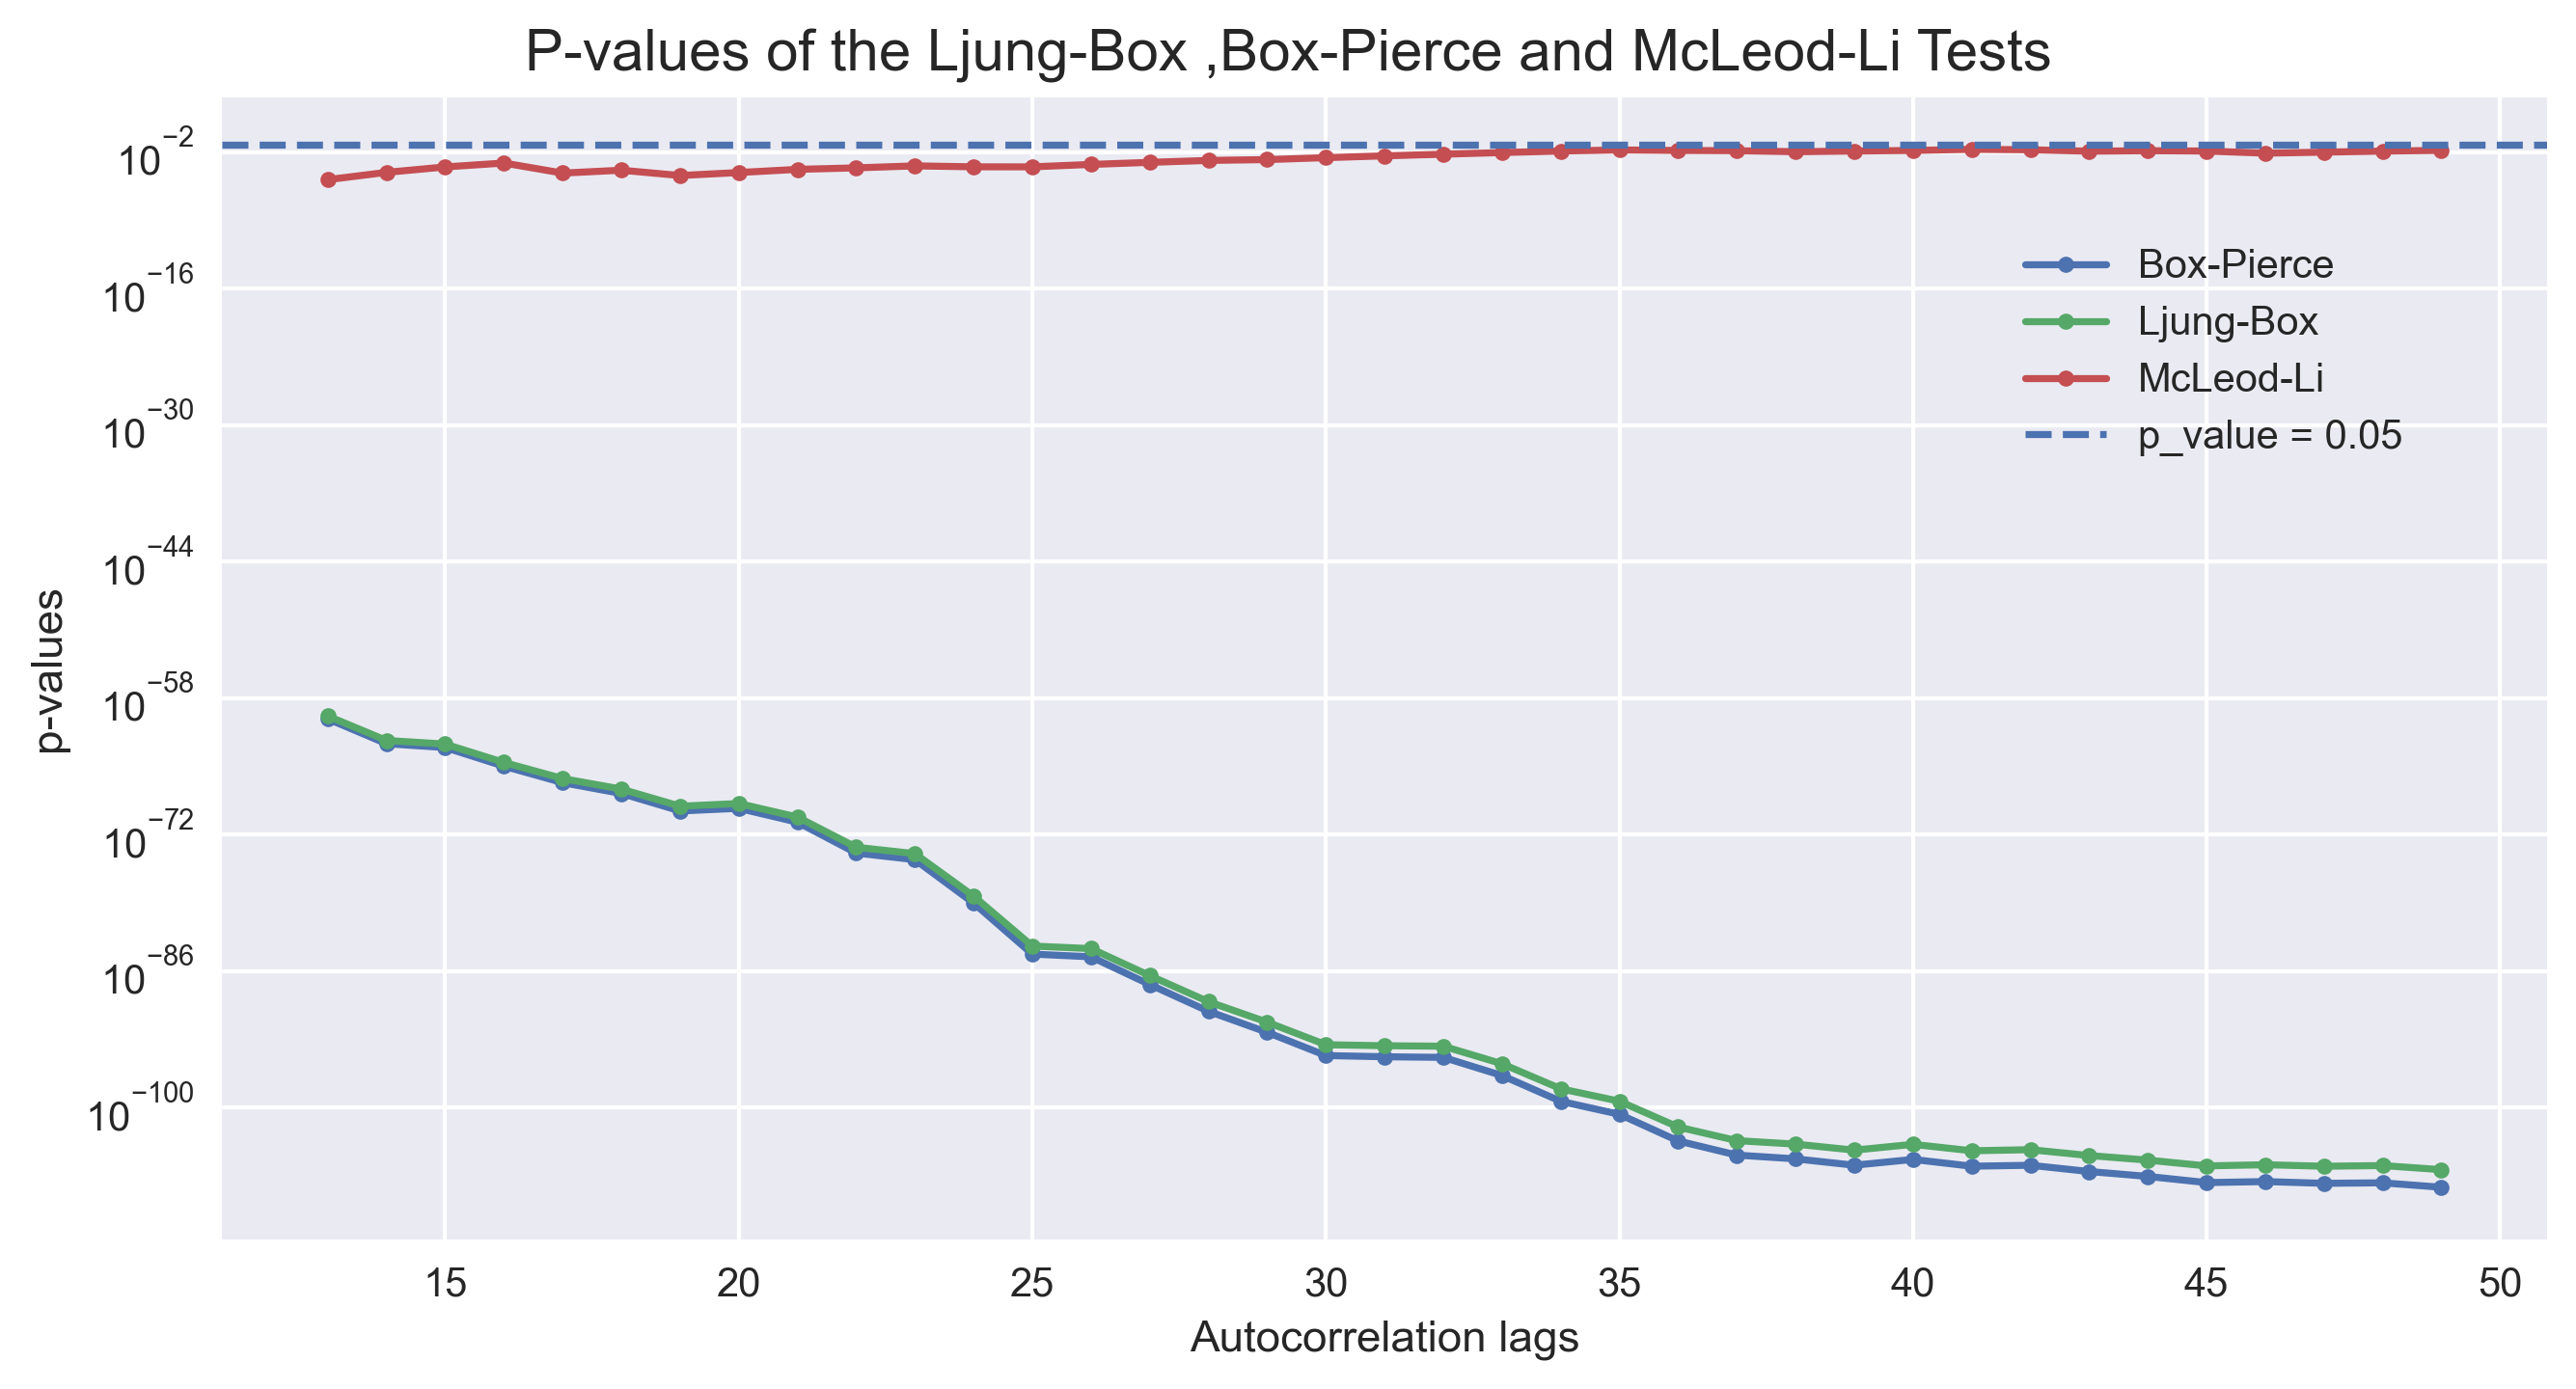

In [1458]:
fig =False
plot_acf_pacf(data_M.Mean_Seasonless,lag=50, title = 'ACF and PACF of monthly seasonless mean temperature'
              ,closefig=fig,fname = 'figure/Monthly/Seasonless1_mean_acf_pacf.png')
plot_ljung_pierce(data_M.Mean_Seasonless,semilog_y = True,loca = (0.78,0.66),closefig=fig
                 ,fname = 'figure/Monthly/Seasonless_mean_Ljung_Pierce.png',df = 12)

#les plots acf et pacf ne permettent pas de rejetter l'hypothèse d'indépendance mais les tests de Ljung et Pierce 
#nous permettent de largement rejetter l'hypothèse d'indépendance.

In [1459]:
test_Q = sm.stats.acorr_ljungbox(data_M.Mean_Seasonless, lags=range(1,50), return_df=True,boxpierce=False,model_df = 0)
p_values_McLeod_Li = sm.stats.acorr_ljungbox(data_M.Mean_Seasonless**2, lags=range(1,50), return_df=True,model_df = 0).lb_pvalue
p_values_Ljung = test_Q.lb_pvalue
    
p_values_indep = pd.DataFrame()
p_values_indep['Ljung']=p_values_Ljung
p_values_indep['McLeod']=p_values_McLeod_Li
p_values_indep.to_csv("DataGenerated/Monthly/Monthly1_pvalue_indep_GLS",index=True)

In [1418]:
#Model selection using AIC
p = np.array(np.arange(0,12))
q = np.array(np.arange(0,5))

param = np.array([np.array([int(pp),int(qq)]) for pp in p for qq in q])

AIC = np.zeros(shape=(np.shape(param)[0],))

model_selection = pd.DataFrame(np.array([param[:,0],param[:,1],AIC]).T, columns = ["param_p","param_q","AIC"])

for i, (pp,qq) in enumerate(param):
    arma_mod = ARIMA(data_M.Mean_Seasonless, order=(pp,0,qq)).fit(method = 'innovations_mle')
    model_selection.AIC[i] = arma_mod.aic

i = np.argmin(model_selection.AIC)
mod = model_selection.to_latex()

g = open('txt/Monthly/ModelSelection1_monthly.txt','w')
g.write(mod)
g.close()

In [1419]:
model_selection.to_csv("DataGenerated/Monthly1_modelSelection.csv",index=False)
#model_selection

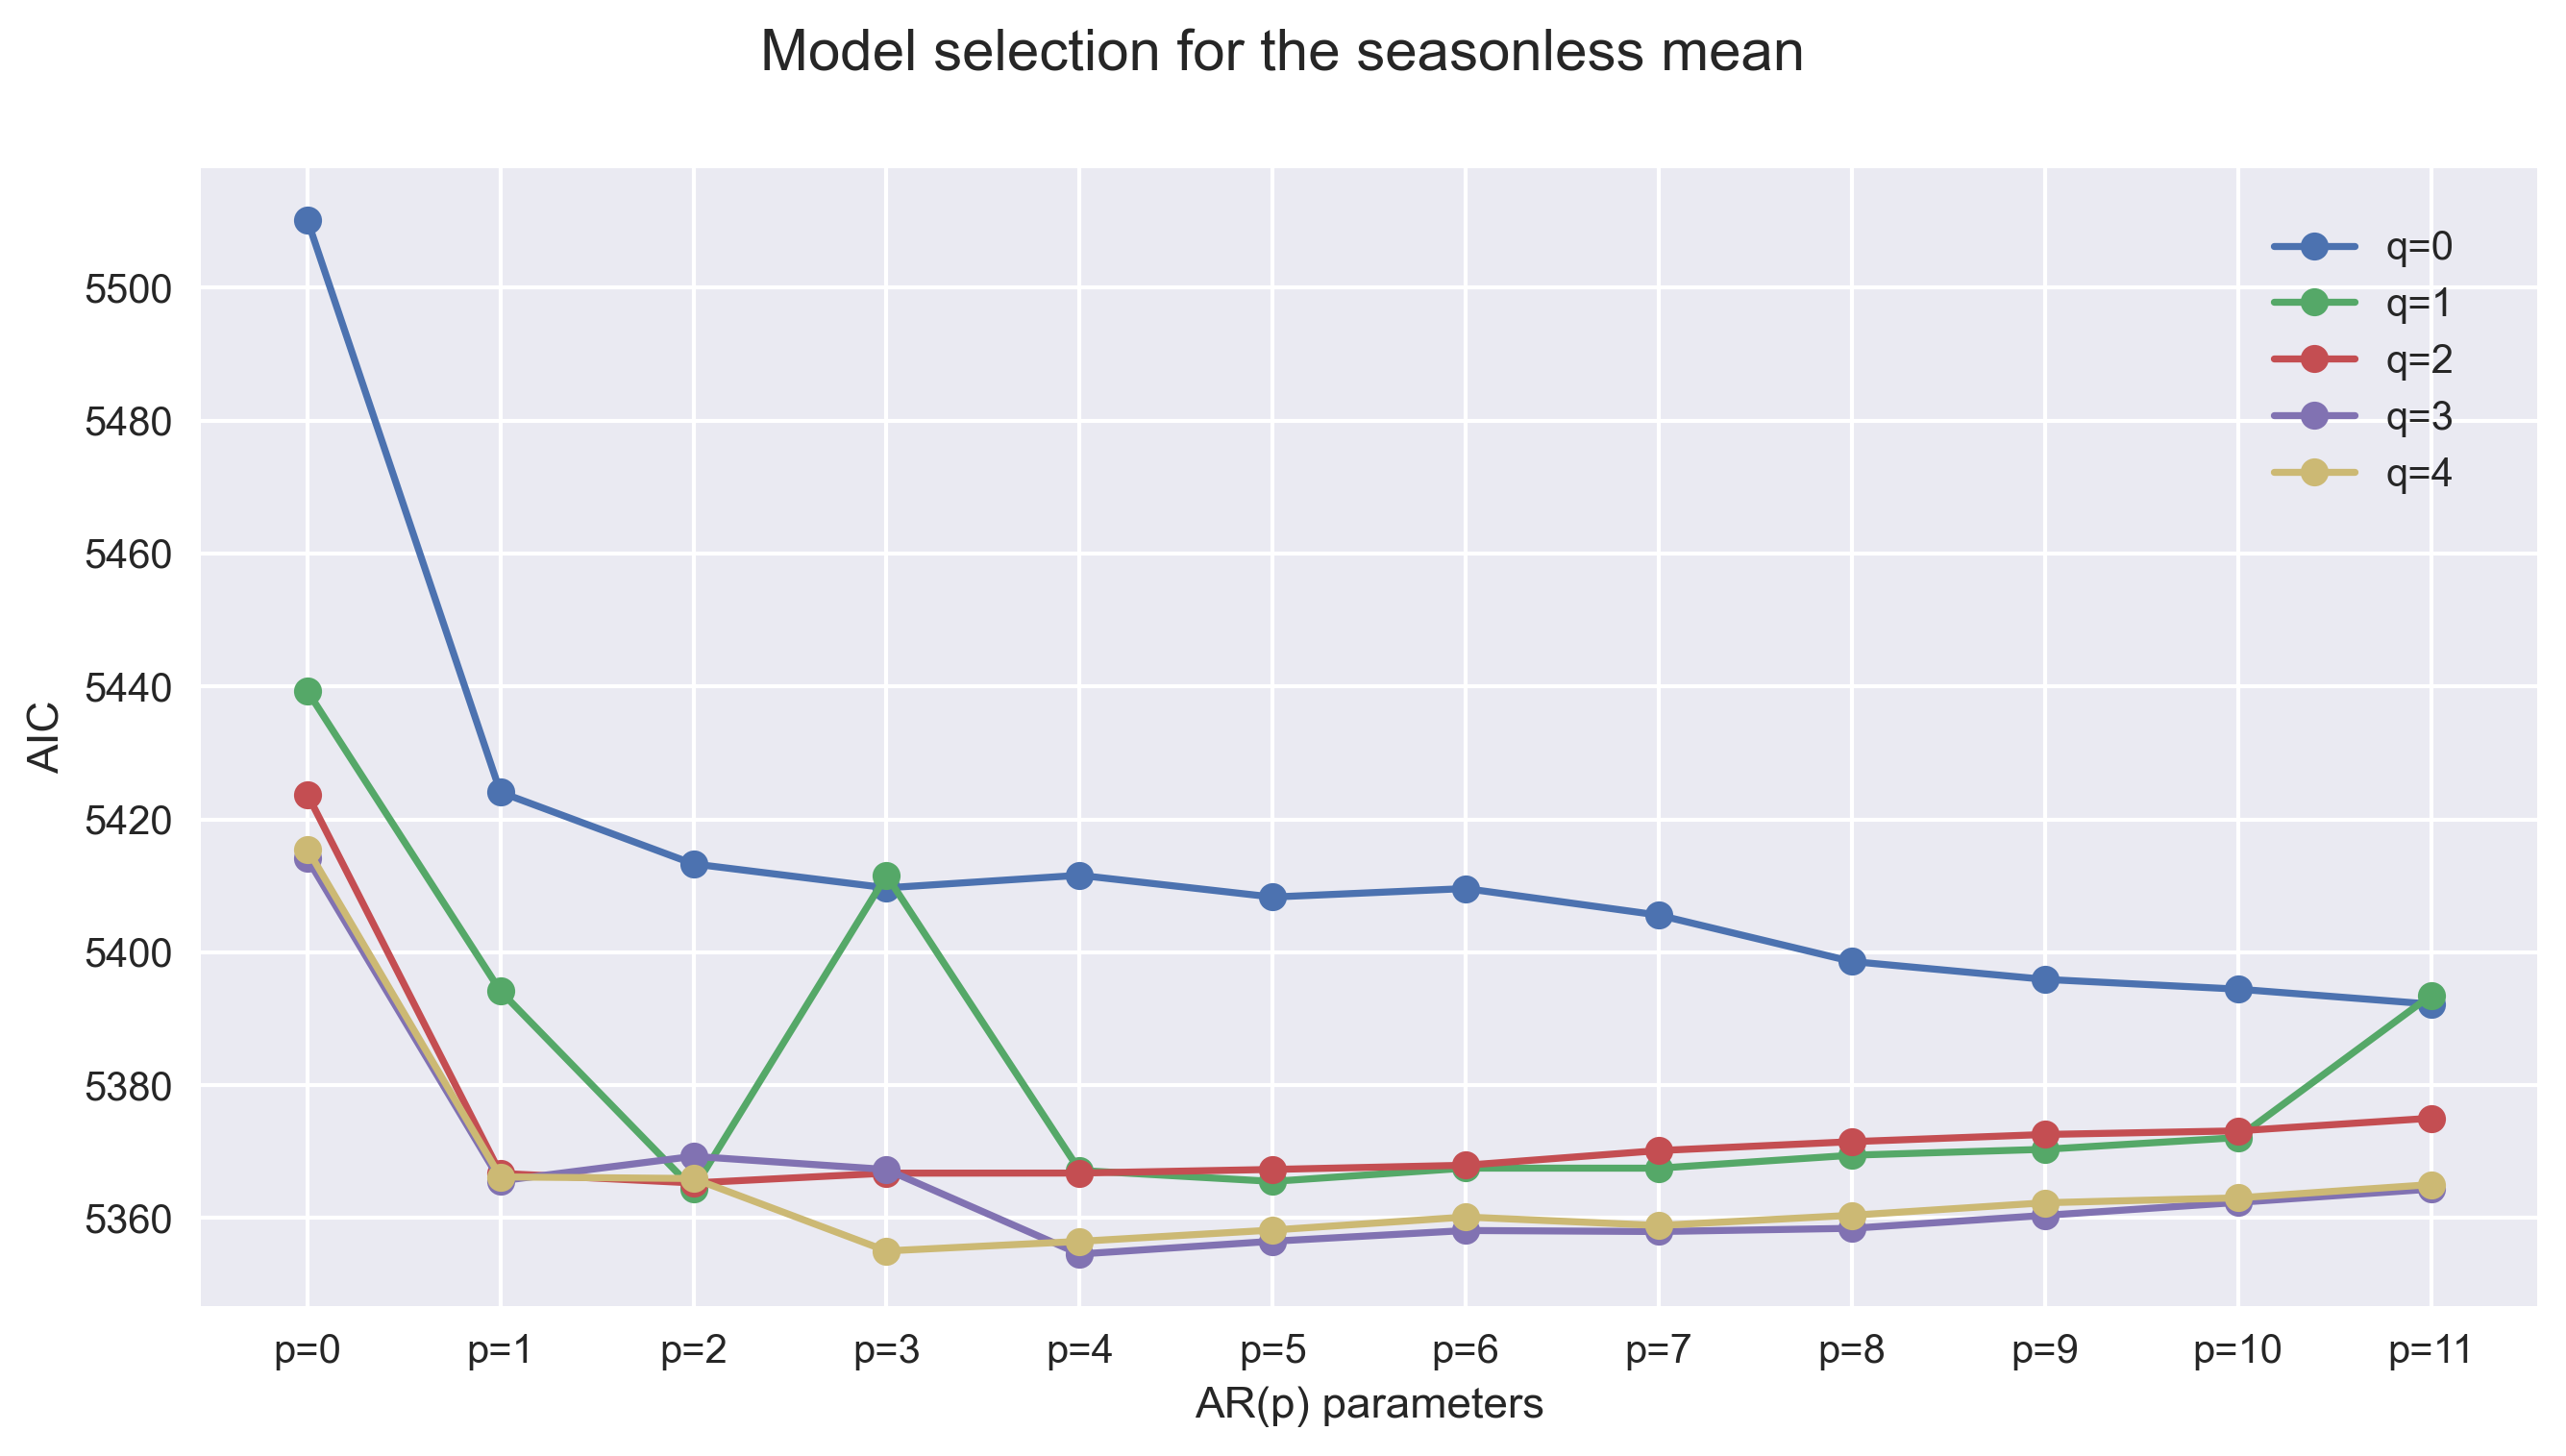

In [1421]:
fig = plt.figure(figsize=(9,5), dpi=300, tight_layout = True)
fig.suptitle("Model selection for the seasonless mean",y = 1,size='x-large',weight = 'roman')

plt.plot(range(0,12),model_selection[model_selection.param_q == 0].AIC,'o-')
plt.plot(range(0,12),model_selection[model_selection.param_q == 1].AIC,'-o')
plt.plot(range(0,12),model_selection[model_selection.param_q == 2].AIC,'o-')
plt.plot(range(0,12),model_selection[model_selection.param_q == 3].AIC,'-o')
plt.plot(range(0,12),model_selection[model_selection.param_q == 4].AIC,'-o')

plt.xlabel('AR(p) parameters')
plt.ylabel('AIC')
qq = ['p=0','p=1','p=2','p=3','p=4','p=5','p=6','p=7','p=8','p=9','p=10','p=11',]
plt.xticks(range(0,12),qq)
fig.legend(['q=0','q=1','q=2','q=3','q=4'],loc = (0.88,0.65))

plt.savefig('figure/Monthly/seasonless_mean_model_selection_AIC', dpi=300, bbox_inches='tight')
#plt.close()

In [1422]:
#On fixe le modèle ARMA(4,3)
p = 4
q = 3
arma_mod = ARIMA(data_M.Mean_Seasonless, order=(p,0,q)).fit(method = 'innovations_mle')
res = arma_mod.resid
data_M["resid"] = res
data_M.loc[:,["Date","resid"]].to_csv("DataGenerated/Monthly/Monthly_arma4_3.csv")

In [1423]:
test_Q = sm.stats.acorr_ljungbox(data_M.resid, lags=range(1,50), return_df=True,boxpierce=False,model_df = 0)
p_values_McLeod_Li = sm.stats.acorr_ljungbox(data_M.resid**2, lags=range(1,50), return_df=True,model_df = 0).lb_pvalue
p_values_Ljung = test_Q.lb_pvalue
    
p_values_indep = pd.DataFrame()
p_values_indep['Ljung']=p_values_Ljung
p_values_indep['McLeod']=p_values_McLeod_Li
p_values_indep.to_csv("DataGenerated/Monthly/Monthly2_pvalue_indep_GLS",index=True)

In [1424]:
summary = arma_mod.summary()

g = open('txt/Monthly/ModelSelection_monthly.txt','w')
g.write(summary.as_latex())
g.close()


In [1425]:
#Stationarity test residu of ARMA model with addfuller
test_addfuller = adfuller(res, maxlag=None, regression='n', autolag='AIC'
                          , store=False, regresults=True)

g = open('txt/Monthly/addfullerTest_monthly1_resARMA.txt','a')
g.write("Monthly Seasonless mean (no constant) (model 1) : p-value = "+str(test_addfuller[1])+'\n')
g.close()
#
test_addfuller[1]
# the p-value of the addfuller test let us think that the time series is stationary

0.0

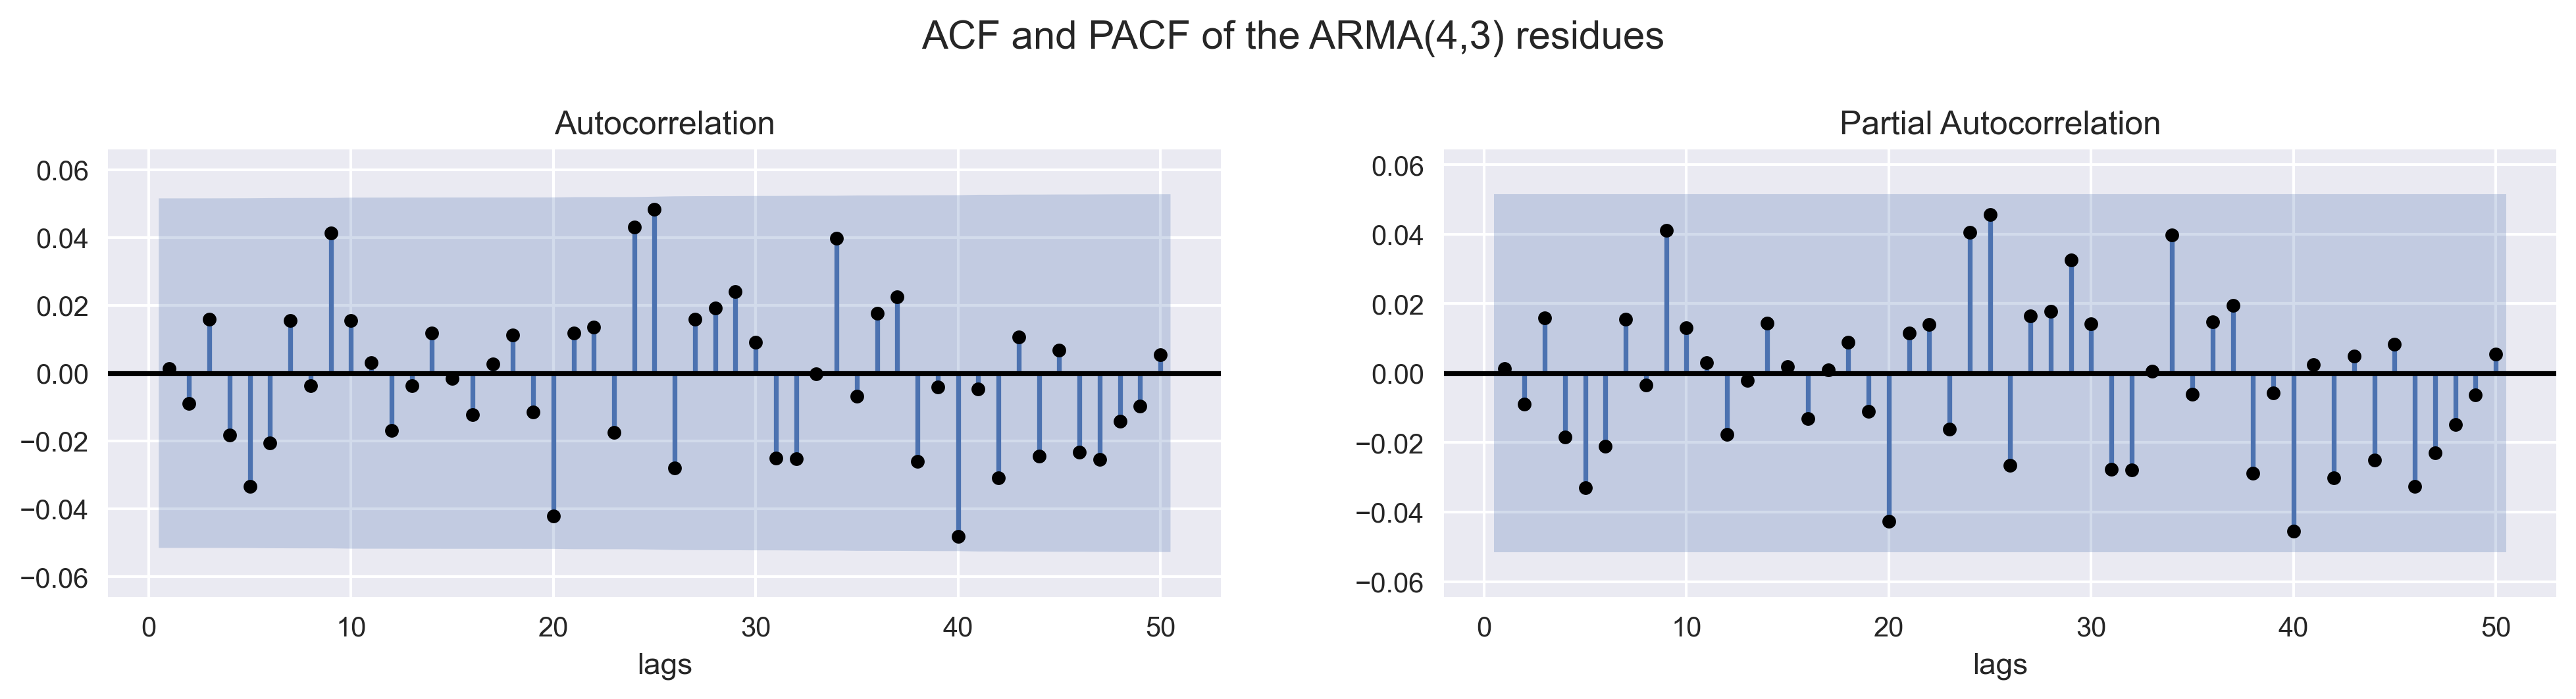

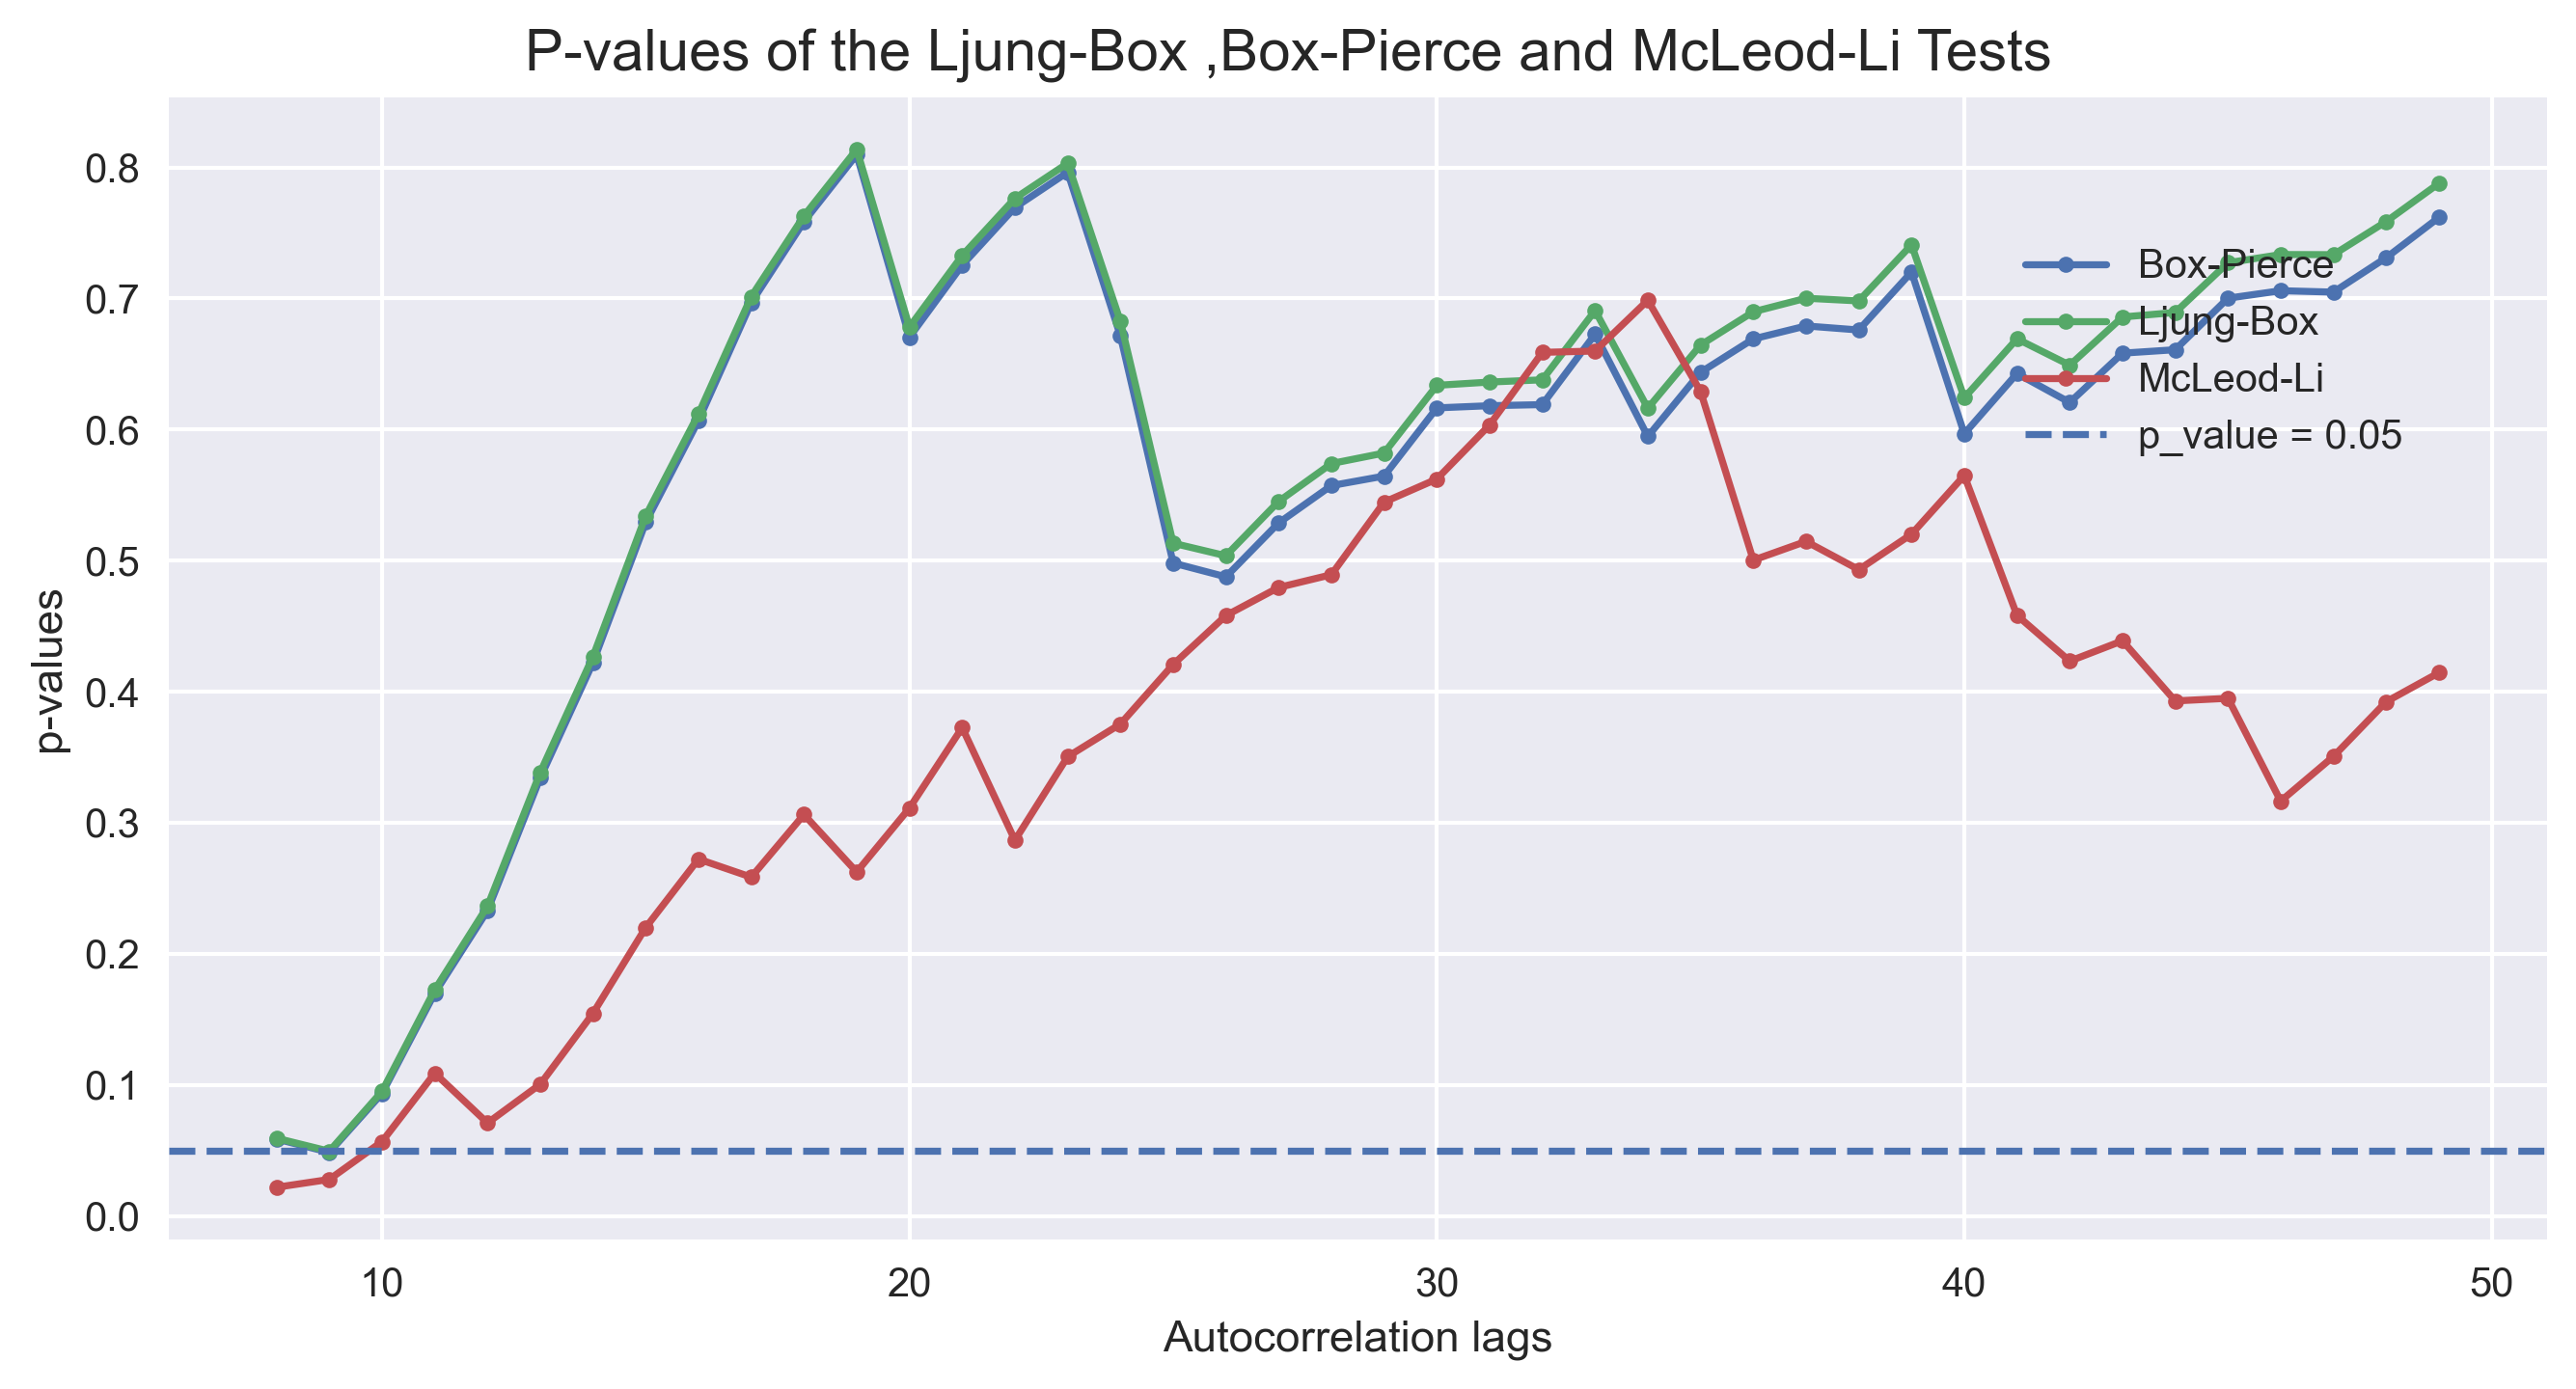

In [1429]:
fig = False
plot_acf_pacf(arma_mod.resid,lag=50, title = 'ACF and PACF of the ARMA(4,3) residues'
              ,closefig=fig,fname = 'figure/Monthly/Seasonless1_1_mean_acf_pacf.png')
plot_ljung_pierce(arma_mod.resid,semilog_y = False,loca = (0.78,0.66),closefig=fig
                 ,fname = 'figure/Monthly/Detrended_mean_Ljung_Pierce.png',df = p+q)
#Nous ne pouvons plus rejetter l'hypothèse d'indépendance.

In [1427]:
#Test de normalité
norm_test = arma_mod.test_normality(method='jarquebera')
hetero_test = arma_mod.test_heteroskedasticity(method='breakvar')

g = open('txt/Annual_resid_normalityCheck.txt','w')
g.write('Normality test : p-value = '+str(norm_test[0,1])+'\n'+'Heteroskedasticity test : p-value = '+str(hetero_test[0,1]))
g.close()

print(norm_test[0,1],hetero_test[0,1])

#Nous pouvons rejetter l'hypothèse nulle de normalité de nos résidus. Cela nous suggère que notre modèle n'est 
#peut-être pas le plus adapté aux données mensuel

8.410477926363701e-15 0.7869069220643125


## Modélisation 2

In [1319]:
# We make a pilot estimate of the covariance matrix

STL_fit = STL(data_M.Mean,period=12).fit()
res = STL_fit.resid

test_addfuller = adfuller(res, maxlag=None, regression='n', autolag='AIC'
                          , store=False, regresults=True)


sigma_estimate = res.var()*sc.linalg.toeplitz(acf(res,nlags=n,fft=False))
#test_addfuller[1]

In [1320]:
# Temperature explain by the years and a intercept depending on the month
tol_conv = 1e-10
n = np.shape(data_M.Mean)[0]
one = np.ones(shape=(np.shape(t)[0],1))

X = np.concatenate([np.array(np.cos(2*(data_M.grid-1901)*np.pi)).reshape((n,1)),np.array(np.sin(2*(data_M.grid-1901)*np.pi)).reshape((n,1)),np.array(data_M.grid).reshape((n,1))],axis = 1)

sigma = sigma_estimate  #data_Y.Mean not stationary so we cannot use acf on it 
sigma_prec = np.eye(n)
reg = sm.GLS(data_M.Mean,X,sigma).fit()
res = reg.resid

#We test the stationarity for use the acf
test_addfuller = adfuller(res, maxlag=None, regression='n', autolag='AIC'
                          , store=False, regresults=True)
iter_stationarity_bool_ = np.array([bool(test_addfuller[1]<0.05)])

while (np.linalg.norm(sigma-sigma_prec)>tol_conv):
    test_addfuller = adfuller(res, maxlag=None, regression='n', autolag='AIC',store=False, regresults=True)
    iter_stationarity_bool_ = np.concatenate([iter_stationarity_bool_,np.array([bool(test_addfuller[1]<0.05)])])
    acf_ = acf(res,nlags=n,fft=False)
    sigma_prec = sigma
    sigma = res.var()*sc.linalg.toeplitz(acf_)
    reg = sm.GLS(data_M.Mean,X,sigma).fit()
    res = reg.resid


coef = reg.params
#print(reg.summary())

In [1321]:
print(iter_stationarity_bool_)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


In [1322]:
data_M["Mean_Seasonless"] = res

In [1323]:
#Stationarity test on seasonless mean with addfuller
test_addfuller = adfuller(data_M.Mean_Seasonless, maxlag=None, regression='n', autolag='AIC'
                          , store=False, regresults=True)

g = open('txt/Monthly/addfullerTest_monthly2.txt','a')
g.write("Monthly Seasonless mean (no constant) (model 2) : p-value = "+str(test_addfuller[1])+'\n')
g.close()

#test_addfuller[1]
# the p-value of the addfuller test let us think that the time series is stationary

In [1324]:
fig = True
plot_acf_pacf(data_M.Mean_Seasonless,lag=50, title = 'ACF and PACF of monthly seasonless mean temperature'
              ,closefig=fig,fname = 'figure/Monthly/Seasonless_mean_acf_pacf.png')
plot_ljung_pierce(data_M.Mean_Seasonless,semilog_y = True,loca = (0.78,0.66),closefig=fig
                 ,fname = 'figure/Monthly/Seasonless_mean_Ljung_Pierce.png',df = 3)

# We can reject the nulle hypothesis of independance

In [1325]:
#Model selection using AIC
p = np.array(np.arange(0,12))
q = np.array(np.arange(0,5))

param = np.array([np.array([int(pp),int(qq)]) for pp in p for qq in q])

AIC = np.zeros(shape=(np.shape(param)[0],))

model_selection = pd.DataFrame(np.array([param[:,0],param[:,1],AIC]).T, columns = ["param_p","param_q","AIC"])

for i, (pp,qq) in enumerate(param):
    arma_mod = ARIMA(data_M.Mean_Seasonless, order=(pp,0,qq)).fit(method = 'innovations_mle')
    model_selection.AIC[i] = arma_mod.aic

i = np.argmin(model_selection.AIC)
mod = model_selection.to_latex()

g = open('txt/Monthly/ModelSelection2_monthly.txt','w')
g.write(mod)
g.close()

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima/estimators/gls.py:296: UserWarning: Feasible GLS failed to converge in 50 iterations. Consider increasing the maximum number of iterations using the `max_iter` argument or reducing the required tolerance using the `tolerance` argument.
  warnings.warn('Feasible GLS failed to converge in %d iterations.'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima/estimators/gls.py:296: UserWarning: Feasible GLS failed to converge in 50 iterations. Consider increasing the maximum number of iterations using the `max_iter` argument or reducing the required tolerance using the `tolerance` argument.
  warnings.warn('Feasible GLS failed to converge in %d iterations.'


In [1326]:
model_selection.to_csv("DataGenerated/Monthly2_modelSelection.csv",index=False)
#model_selection

In [1327]:
fig = plt.figure(figsize=(9,5), dpi=300, tight_layout = True)
fig.suptitle("Model selection for the seasonless mean",y = 1,size='x-large',weight = 'roman')

plt.plot(range(0,12),model_selection[model_selection.param_q == 0].AIC,'o-')
plt.plot(range(0,12),model_selection[model_selection.param_q == 1].AIC,'-o')
plt.plot(range(0,12),model_selection[model_selection.param_q == 2].AIC,'o-')
plt.plot(range(0,12),model_selection[model_selection.param_q == 3].AIC,'-o')
plt.plot(range(0,12),model_selection[model_selection.param_q == 4].AIC,'-o')

plt.xlabel('AR(p) parameters')
plt.ylabel('AIC')
qq = ['p=0','p=1','p=2','p=3','p=4','p=5','p=6','p=7','p=8','p=9','p=10','p=11',]
plt.xticks(range(0,12),qq)
fig.legend(['q=0','q=1','q=2','q=3','q=4'],loc = (0.89,0.66))

plt.savefig('figure/Monthly/seasonless_mean_model_selection2_AIC', dpi=300, bbox_inches='tight')
plt.close()

In [1328]:
#On fixe le modèle ARMA(5,4)
p = 5
q = 4
arma_mod = ARIMA(data_M.Mean_Seasonless, order=(p,0,q)).fit(method = 'innovations_mle')
res = arma_mod.resid

In [1329]:
summary = arma_mod.summary()

g = open('txt/Monthly/ModelSelection_monthly.txt','w')
g.write(summary.as_latex())
g.close()

In [1330]:
#Stationarity test on residu of ARMA with addfuller
test_addfuller = adfuller(data_M.Mean_Seasonless, maxlag=None, regression='n', autolag='AIC'
                          , store=False, regresults=True)

g = open('txt/Monthly/addfullerTest_monthly2.txt','a')
g.write("Monthly Seasonless mean (no constant) (model 2) : p-value = "+str(test_addfuller[1])+'\n')
g.close()

#test_addfuller[1]
# the p-value of the addfuller test let us think that the time series is stationary

In [1331]:
fig = True
plot_acf_pacf(res,lag=50, title = 'ACF and PACF of the ARMA(4,3) residues'
              ,closefig=fig,fname = 'figure/Monthly/Seasonless_mean_acf_pacf.png')
plot_ljung_pierce(res,semilog_y = False,loca = (0.78,0.66),closefig=fig
                 ,fname = 'figure/Monthly/Detrended_mean_Ljung_Pierce.png',df = p+q)

In [1332]:
#Test de normalité
norm_test = arma_mod.test_normality(method='jarquebera')
hetero_test = arma_mod.test_heteroskedasticity(method='breakvar')

g = open('txt/Annual_resid_normalityCheck.txt','w')
g.write('Normality test : p-value = '+str(norm_test[0,1])+'\n'+'Heteroskedasticity test : p-value = '+str(hetero_test[0,1]))
g.close()

print(norm_test[0,1],hetero_test[0,1])
# We can reject the nulle hypothesis of normality

8.239084297162395e-15 0.9917823060079507


## Modélisation 3

Modélisation séparé pour chaque mois en suivant la procédure utilisée pour modéliser les moyennes annuellles.

In [1217]:
GLS_result = pd.DataFrame(np.zeros((12,7)), columns=["const","trend","R2","R2_adj","p_value","conf_inf","conf_sup"])

f = lambda x,i: GLS_result.iloc[i-1,0]+GLS_result.iloc[i-1,1]*x
tol_conv = 1e-010

for m in range(12):
    n = np.shape(data_M[data_M.Month == float(m+1)].Mean)[0]
    t = np.array(data_M[data_M.Month == float(m+1)].Years).reshape((n,1))
    one = np.ones(shape=(n,1))
    X = np.concatenate([one,t],axis = 1)
    #------------------------
    
    frac = np.arange(1./n,1,1./n)
    i = 1

    dens = sm.nonparametric.lowess(data_M[data_M.Month == float(m+1)].Mean,np.arange(n),frac=frac[-i] )
    test_addfuller = adfuller(dens[:,1], maxlag=None, regression='n', autolag='AIC'
                              , store=False, regresults=True)
    
    while (test_addfuller[1]>0.05):
        i+=1
        dens = sm.nonparametric.lowess(data_M[data_M.Month == float(m+1)].Mean,np.arange(n),frac=frac[-i])
        test_addfuller = adfuller(data_M[data_M.Month == float(m+1)].Mean-dens[:,1], maxlag=None, regression='n', autolag='AIC'
                              , store=False, regresults=True)

    #We can reject the fact that the time series is not stationary, therefore we could use the acf
    res = data_M[data_M.Month == float(m+1)].Mean-dens[:,1]
    acf_estimate = acf(res,nlags=n,fft=False)
    sigma_estimate = res.var()*sc.linalg.toeplitz(acf_estimate)
    #------------------------
    sigma_ = sigma_estimate
    sigma_prec = np.eye(n)
    reg = sm.GLS(data_M[data_M.Month == float(m+1)].Mean,X,sigma_).fit()
    res = reg.resid
    
    while (np.linalg.norm(sigma_-sigma_prec)>tol_conv):
        acf_ = acf(res,nlags=n,fft=False)
        sigma_prec = sigma_
        sigma_ = res.var()*sc.linalg.toeplitz(acf_)
        reg = sm.GLS(data_M[data_M.Month == float(m+1)].Mean,X,sigma_).fit()
        res = reg.resid
        
    CI = reg.conf_int().loc["x1"]
    GLS_result.loc[m,:] = np.array([reg.params[0],reg.params[1],reg.rsquared,reg.rsquared_adj,reg.pvalues[1],
                                   CI[0],CI[1]])

In [1218]:
data_M["Monthly_Detrended_Mean"] = data_M.Mean - np.array([f(data_M.Years[i],int(data_M.Month[i])) 
                                                           for i in range(np.shape(data_M.Mean)[0])])
print(GLS_result)

        const     trend        R2    R2_adj       p_value  conf_inf  conf_sup
0  -24.460784  0.013090  0.081915  0.074200  1.460279e-03  0.005135  0.021044
1  -19.605519  0.011198  0.244358  0.238008  8.290344e-09  0.007624  0.014772
2  -14.209616  0.010229  0.081654  0.073936  1.487284e-03  0.004002  0.016456
3   -2.409662  0.006112  0.019105  0.010862  1.305601e-01 -0.001837  0.014060
4    4.187399  0.004924  0.011286  0.002977  2.461614e-01 -0.003441  0.013289
5    4.159443  0.006763  0.014892  0.006613  1.824025e-01 -0.003222  0.016748
6   -2.494367  0.011306  0.080402  0.072675  1.623467e-03  0.004366  0.018246
7   -3.553848  0.011443  0.092349  0.084721  7.025348e-04  0.004931  0.017956
8    7.175712  0.004187  0.019890  0.011584  1.244267e-01 -0.001171  0.009545
9  -20.137183  0.015561  0.206255  0.199529  1.888305e-07  0.009996  0.021125
10 -13.422524  0.009618  0.115826  0.108333  1.427768e-04  0.004774  0.014462
11 -16.514270  0.009578  0.057407  0.049419  8.396440e-03  0.002

In [1118]:
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8),(ax9,ax10),(ax11,ax12)) = plt.subplots(6,2,figsize=(18,12))
axs = (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12)
fig.suptitle("Trendless mean temperature by month",y = 0.95,size='xx-large',weight = 'roman')
for m in Months:
    Y = data_M[data_M.Month == m].Years.unique()
    axs[m-1].plot(Y,data_M[data_M.Month==m].Monthly_Detrended_Mean, color = 'k')
    axs[m-1].set_title(calendar.month_name[int(m)])
    plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.8)

    axs[m-1].set_xlabel("Years")
    axs[m-1].set_ylabel("Temperature(°C)",fontsize=8)


plt.savefig("figure/Monthly/Monthly_detrended_mean.png", dpi=300, bbox_inches='tight')
plt.close(fig)

In [1119]:
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8),(ax9,ax10),(ax11,ax12)) = plt.subplots(6,2,figsize=(18,12))
axs = (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12)
fig.suptitle("Modelisation of the linear trend of the mean temperature by month",y = 0.95,size='xx-large',weight = 'roman')
for m in Months:
    Y = data_M[data_M.Month == m].Years.unique()
    axs[m-1].plot(Y,data_M[data_M.Month==m].Mean, color = 'k')
    axs[m-1].plot(Y,f(Y,int(m)), color = 'b')
    axs[m-1].set_title(calendar.month_name[int(m)])
    plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.8)

    axs[m-1].set_xlabel("Years")
    axs[m-1].set_ylabel("Temperature(°C)",fontsize=8)

plt.savefig("figure/Monthly/Monthly_mean_modelisation.png", dpi=300, bbox_inches='tight')
plt.close(fig)

In [1164]:
#Test Q de Ljung-Box

test_Q = [sm.stats.acorr_ljungbox(data_M[data_M.Month == float(m)].Monthly_Detrended_Mean, lags=range(1,50), return_df=True) for m in Months]

#p_values_Ljung = [test_Q[i].lb_pvalue for i in range(12)]

fig,ax = plt.subplots(2,1,figsize=(12,8), dpi=300, tight_layout = True)
fig.suptitle("P-values of the Ljung-Box Q Test for each monthly detrended mean",y = 1
             ,size='x-large',weight = 'roman')


for i in range(6):
    ax[0].plot(test_Q[i].lb_pvalue,'-o',markersize = 4,label=calendar.month_name[i+1])
    ax[1].plot(test_Q[i+6].lb_pvalue,'-o',markersize = 4,label=calendar.month_name[i+7])
    

#plt.semilogy()
ax[0].axhline(y=0.05,linestyle='--',label='p_value = '+str(0.05))
ax[0].legend(loc = (0.85,0.45))
ax[1].axhline(y=0.05,linestyle='--',label='p_value = '+str(0.05))
ax[1].legend(loc = (0.85,0.45))
ax[0].set_xlabel('Autocorrelation lags')
ax[0].set_ylabel('p-values')
ax[1].set_xlabel('Autocorrelation lags')
ax[1].set_ylabel('p-values')

plt.savefig("figure/Monthly/p_values_Ljung_Test_detrended_mean4.png", dpi=300, bbox_inches='tight')
plt.close(fig)

In [1141]:
norm_test = [sc.stats.normaltest(data_M[data_M.Month == float(m)].Monthly_Detrended_Mean).pvalue for m in Months]
(np.array(norm_test)>0.05)

array([ True, False,  True,  True, False, False,  True,  True,  True,
       False,  True,  True])

In [1142]:
#Model selection using AIC for each Month
p = np.array(np.arange(0,4))
q = np.array(np.arange(0,10))

param = np.array([np.array([int(pp),int(qq)]) for pp in p for qq in q])

model_selection = np.zeros(shape=(12,np.shape(p)[0],np.shape(q)[0]))

for m in range(12):
    for i, (pp,qq) in enumerate(param):
        arma_mod = ARIMA(data_M[data_M.Month == float(m+1)].Monthly_Detrended_Mean, order=(pp,0,qq)).fit(method = 'innovations_mle')
        model_selection[m,pp,qq] = arma_mod.aic

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

In [1143]:
mean_aic = model_selection.mean(axis = 0)
np.save("DataGenerated/model_selction_byMonth.npy",model_selection)

In [1145]:
fig = plt.figure(figsize=(9,5), dpi=300, tight_layout = True)
fig.suptitle("Model selection for the detrended mean",y = 1,size='x-large',weight = 'roman')

plt.plot(range(0,10),mean_aic[0,:],'o-')
plt.plot(range(0,10),mean_aic[1,:],'-o')
plt.plot(range(0,10),mean_aic[2,:],'o-')
plt.plot(range(0,10),mean_aic[3,:],'-o')

plt.xlabel('MA(p) parameters')
plt.ylabel('AIC')
qq = ['q=0','q=1','q=2','q=3','q=4','q=5','q=6','q=7','q=8','q=9']
plt.xticks(range(0,10),qq)
fig.legend(['p=0','p=1','p=2','p=3'],loc = (0.09,0.69))

plt.savefig('figure/Monthly/detrended_mean_model_selection2_AIC_MbyM', dpi=300, bbox_inches='tight')
plt.close()

# In order to choose a unique model for the modelisation on the detrended mean of each month, we look at the mean 
# of the AIC across month. This way of choose the model suggests to us the model ARMA(2,2).

In [1208]:
p, q = 2, 2

arma_mod = [ARIMA(data_M[data_M.Month == float(m+1)].Monthly_Detrended_Mean, 
                  order=(p,0,q)).fit(method = 'innovations_mle') for m in range(12)]

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [1209]:
#Test Q de Ljung-Box

test_Q = [sm.stats.acorr_ljungbox(arma_mod[m-1].resid, lags=range(1,50), return_df=True) for m in Months]

fig,ax = plt.subplots(2,1,figsize=(12,8), dpi=300)
fig.suptitle("P-values of the Ljung-Box Q Test for each monthly residues",y = 0.95
             ,size='x-large',weight = 'roman')

for i in range(6):
    ax[0].plot(test_Q[i].lb_pvalue,'-o',markersize = 4,label=calendar.month_name[i+1])
    ax[1].plot(test_Q[i+6].lb_pvalue,'-o',markersize = 4,label=calendar.month_name[i+7])
    

#plt.semilogy()
ax[0].axhline(y=0.05,linestyle='--',label='p_value = '+str(0.05))
ax[0].legend(loc = (0.005,0.07))
ax[1].axhline(y=0.05,linestyle='--',label='p_value = '+str(0.05))
ax[1].legend(loc = (0.005,0.07))
ax[0].set_xlabel('Autocorrelation lags')
ax[0].set_ylabel('p-values')
ax[1].set_xlabel('Autocorrelation lags')
ax[1].set_ylabel('p-values')

plt.savefig("figure/Monthly/p_values_Ljung_Test_detrended_mean_ARMA2_2.png", dpi=300, bbox_inches='tight')
plt.close(fig)
# We cannot reject the nulle hypothesis of independance

In [1211]:
norm_test = [sc.stats.jarque_bera(arma_mod[m-1].resid).pvalue for m in Months]

fig = plt.figure(figsize=(14,4), dpi=300)
fig.suptitle("P-values of the normal test on the residus of the ARMA(2,2) model",y = 0.95
             ,size='x-large',weight = 'roman')
colors = list()

for i in range(12):
    if (norm_test[i]<=0.05): 
        colors = colors + list('r')
    else : 
        colors = colors + list('g')

for i in range(12):
    plt.plot(calendar.month_name[i+1],norm_test[i],'-o',markersize = 8,
             color=colors[i])
    
plt.axhline(y=0.05,linestyle='--',label='p_value='+str(0.05))
fig.legend(loc = (0.82,0.8))
plt.xlabel('Month')
plt.ylabel('p-values')

plt.savefig("figure/Monthly/p_values_normalTest_detrended_mean_ARMA2_2.png", dpi=300, bbox_inches='tight')
plt.close(fig)


In [1212]:
model = [np.unravel_index(np.argmin(model_selection[m], axis=None), model_selection[m].shape) for m in range(12)]

In [1213]:
arma_mod = [ARIMA(data_M[data_M.Month == float(m+1)].Monthly_Detrended_Mean, 
                  order=(model[m-1][0],0,model[m-1][1])).fit(method = 'innovations_mle') for m in range(12)]

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

In [1216]:
#Test Q de Ljung-Box

test_Q = [sm.stats.acorr_ljungbox(arma_mod[m-1].resid, lags=range(1,50), return_df=True) for m in Months]

fig = plt.figure(figsize=(10,4), dpi=300)
fig.suptitle("P-values of the Ljung-Box Q Test for each monthly residues",y = 0.95
             ,size='x-large',weight = 'roman')

for i in range(12):
    plt.plot(test_Q[i].lb_pvalue,'-o',markersize = 4,label=calendar.month_name[i])

#plt.semilogy()
plt.axhline(y=0.05,linestyle='--',label='p_value='+str(0.05))
fig.legend(loc = (0.85,0.2))
plt.xlabel('Autocorrelation lags')
plt.ylabel('p-values')

plt.savefig("figure/Monthly/p_values_Ljung_Test_detrended_mean_ARMA_by_month.png", dpi=300, bbox_inches='tight')
plt.close(fig)

In [1215]:
norm_test = [sc.stats.jarque_bera(arma_mod[m-1].resid).pvalue for m in Months]
print(np.array(norm_test)>0.05)
norm_test = [sc.stats.jarque_bera(data_M[data_M.Month == float(m)].Monthly_Detrended_Mean).pvalue for m in Months]
print(np.array(norm_test)>0.05)

[ True False  True  True  True False  True  True  True  True  True  True]
[ True False  True  True  True False  True  True  True False  True  True]


# Modelisation 4

In [1387]:
# We make a pilot estimate of the covariance matrix

STL_fit = STL(data_M.Mean,period=12).fit()
res = STL_fit.resid

test_addfuller = adfuller(res, maxlag=None, regression='n', autolag='AIC'
                          , store=False, regresults=True)


sigma_estimate = res.var()*sc.linalg.toeplitz(acf(res,nlags=n,fft=False))
#test_addfuller[1]

In [1432]:
# Temperature explain by the years and a intercept depending on the month
tol_conv = 1e-010
n = np.shape(data_M.Mean)[0]
t = np.array(data_M.Mean).reshape((n,1))
one = np.ones(shape=(np.shape(t)[0],1))
d = np.concatenate([np.array([(data_M.Month == float(i))]).reshape((n,1)) for i in np.arange(1,13)],axis = 1)
d1 = np.concatenate([np.array((data_M.Month == float(i))*(data_M.Years-1900)).reshape((n,1)) for i in np.arange(1,13)],axis = 1)
#d2 = data_M.Years.copy()-1900
#D2 = np.array(d2).reshape((n,1))
X = np.concatenate([d,d1],axis = 1)


sigma = sigma_estimate  #data_Y.Mean not stationary so we cannot use acf on it 
sigma_prec = np.eye(n)
reg = sm.GLS(data_M.Mean,X,sigma).fit()
res = reg.resid

#We test the stationarity for use the acf
test_addfuller = adfuller(res, maxlag=None, regression='n', autolag='AIC'
                          , store=False, regresults=True)
iter_stationarity_bool_ = np.array([bool(test_addfuller[1]<0.05)])

while (np.linalg.norm(sigma-sigma_prec)>tol_conv):
    test_addfuller = adfuller(res, maxlag=None, regression='n', autolag='AIC',store=False, regresults=True)
    iter_stationarity_bool_ = np.concatenate([iter_stationarity_bool_,np.array([bool(test_addfuller[1]<0.05)])])
    acf_ = acf(res,nlags=n,fft=False)
    sigma_prec = sigma
    sigma = res.var()*sc.linalg.toeplitz(acf_)
    reg = sm.GLS(data_M.Mean,X,sigma).fit()
    res = reg.resid


coef = reg.params
#print(reg.summary())

In [1433]:
print(iter_stationarity_bool_)
#print(reg.summary())


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]


In [1434]:
summary2 = reg.summary()
g = open('DataGenerated/Monthly/summary2_GLS','w')
g.write(summary2.as_html())
g.close()
#summary2

In [1435]:
f_ = lambda t,m: coef[int(m-1)] + coef[int(11+m)]*t

In [1436]:
monthly2_seasonless_gls = pd.DataFrame()
monthly2_seasonless_gls["Date"] = data_M.Date
monthly2_seasonless_gls["Years"] = data_M.Years
monthly2_seasonless_gls["Month"] = data_M.Month
monthly2_seasonless_gls['resid'] = res
monthly2_seasonless_gls['estimation'] = data_M.Mean-reg.resid
monthly2_seasonless_gls .to_csv("DataGenerated/Monthly/Monthly2_seasonless_GLS.csv",index=True)

In [1437]:
data_M["Mean_Seasonless"] = res

In [1438]:
fig, ax = plt.subplots(1,1,figsize=(30,4), dpi= 300)
fig.suptitle("Modelisation of the seasonality",y = 1.,size='x-large',weight = 'roman')
plt.plot(data_M.grid,data_M.Mean-res)
ax.set(xlabel="Years",ylabel="Temperature(°C)")
plt.savefig("figure/Monthly4_seasonality_TimeSeries.png", dpi=300, bbox_inches='tight')
plt.close(fig)

In [1439]:
fig, ax = plt.subplots(1,1,figsize=(30,4), dpi= 300)
fig.suptitle("Modelisation of the seasonality",y = 1.,size='x-large',weight = 'roman')
plt.plot(data_M.grid,res)
ax.set(xlabel="Years",ylabel="Temperature(°C)")
plt.savefig("figure/Monthly4_seasonless_TimeSeries.png", dpi=300, bbox_inches='tight')
plt.close(fig)

In [1440]:
#Stationarity test on seasonless mean with addfuller
test_addfuller = adfuller(data_M.Mean_Seasonless, maxlag=None, regression='n', autolag='AIC'
                          , store=False, regresults=True)

g = open('txt/Monthly/addfullerTest_monthly4.txt','a')
g.write("Monthly Seasonless mean (no constant) (model 1) : p-value = "+str(test_addfuller[1])+'\n')
g.close()
test_addfuller[1]
# the p-value of the addfuller test let us think that the time series is stationary

4.3939664187988985e-05

In [1441]:
test_Q = sm.stats.acorr_ljungbox(data_M.Mean_Seasonless, lags=range(1,50), return_df=True,boxpierce=True,model_df = 0)
p_values_McLeod_Li = sm.stats.acorr_ljungbox(data_M.Mean_Seasonless**2, lags=range(1,50), return_df=True,model_df = 0).lb_pvalue
p_values_Pierce = test_Q.bp_pvalue
p_values_Ljung = test_Q.lb_pvalue

p_values_indep = pd.DataFrame()
p_values_indep['Ljung']=p_values_Ljung
p_values_indep['Pierce']=p_values_Pierce
p_values_indep['McLeod']=p_values_McLeod_Li
p_values_indep.to_csv("DataGenerated/Monthly/Monthly4_pvalue_indep_GLS",index=True)

In [1442]:
fig = True
plot_acf_pacf(data_M.Mean_Seasonless,lag=50, title = 'ACF and PACF of monthly seasonless mean temperature'
              ,closefig=fig,fname = 'figure/Monthly/Seasonless4_mean_acf_pacf.png')
plot_ljung_pierce(data_M.Mean_Seasonless,semilog_y = True,loca = (0.78,0.66),closefig=fig
                 ,fname = 'figure/Monthly/Seasonless_mean_Ljung_Pierce.png',df = 12)

#les plots acf et pacf ne permettent pas de rejetter l'hypothèse d'indépendance mais les tests de Ljung et Pierce 
#nous permettent de largement rejetter l'hypothèse d'indépendance.

In [1443]:
#Model selection using AIC
p = np.array(np.arange(0,12))
q = np.array(np.arange(0,5))

param = np.array([np.array([int(pp),int(qq)]) for pp in p for qq in q])

AIC = np.zeros(shape=(np.shape(param)[0],))

model_selection = pd.DataFrame(np.array([param[:,0],param[:,1],AIC]).T, columns = ["param_p","param_q","AIC"])

for i, (pp,qq) in enumerate(param):
    arma_mod = ARIMA(data_M.Mean_Seasonless, order=(pp,0,qq)).fit(method = 'innovations_mle')
    model_selection.AIC[i] = arma_mod.aic

i = np.argmin(model_selection.AIC)
mod = model_selection.to_latex()

g = open('txt/Monthly/ModelSelection4_monthly.txt','w')
g.write(mod)
g.close()

In [1460]:
model_selection.to_csv("DataGenerated/Monthly/Monthly4_modelSelection.csv",index=False)
#model_selection

In [1445]:
fig = plt.figure(figsize=(9,5), dpi=300, tight_layout = True)
fig.suptitle("Model selection for the seasonless mean",y = 1,size='x-large',weight = 'roman')

plt.plot(range(0,12),model_selection[model_selection.param_q == 0].AIC,'o-')
plt.plot(range(0,12),model_selection[model_selection.param_q == 1].AIC,'-o')
plt.plot(range(0,12),model_selection[model_selection.param_q == 2].AIC,'o-')
plt.plot(range(0,12),model_selection[model_selection.param_q == 3].AIC,'-o')
plt.plot(range(0,12),model_selection[model_selection.param_q == 4].AIC,'-o')

plt.xlabel('AR(p) parameters')
plt.ylabel('AIC')
qq = ['p=0','p=1','p=2','p=3','p=4','p=5','p=6','p=7','p=8','p=9','p=10','p=11',]
plt.xticks(range(0,12),qq)
fig.legend(['q=0','q=1','q=2','q=3','q=4'],loc = (0.88,0.65))

plt.savefig('figure/Monthly/seasonless_mean_model_selection4_AIC', dpi=300, bbox_inches='tight')
plt.close()

In [1467]:
#On fixe le modèle ARMA(5,4)
p = 5
q = 4
arma_mod = ARIMA(data_M.Mean_Seasonless, order=(p,0,q)).fit(method = 'innovations_mle')
res = arma_mod.resid
print(arma_mod.params)
data_M["resid_arma"] = arma_mod.resid
data_M.loc[:,["Date","resid_arma"]].to_csv("DataGenerated/Monthly/Monthly_resid_ARMA5_4.csv",index=True)

const     0.066907
ar.L1     0.736207
ar.L2     0.333038
ar.L3     0.646002
ar.L4    -0.870846
ar.L5     0.151297
ma.L1    -0.548907
ma.L2    -0.385397
ma.L3    -0.750094
ma.L4     0.709441
sigma2    2.332042
dtype: float64


In [1469]:
test_Q = sm.stats.acorr_ljungbox(data_M.resid_arma, lags=range(1,50), return_df=True,boxpierce=True,model_df = 0)
p_values_McLeod_Li = sm.stats.acorr_ljungbox(data_M.resid_arma**2, lags=range(1,50), return_df=True,model_df = 0).lb_pvalue
p_values_Pierce = test_Q.bp_pvalue
p_values_Ljung = test_Q.lb_pvalue

p_values_indep = pd.DataFrame()
p_values_indep['Ljung']=p_values_Ljung
p_values_indep['Pierce']=p_values_Pierce
p_values_indep['McLeod']=p_values_McLeod_Li
p_values_indep.to_csv("DataGenerated/Monthly/Monthly4_pvalue_indep_arma5_4",index=True)

In [1447]:
summary = arma_mod.summary()

g = open('txt/Monthly/ModelSelection_monthly.txt','w')
g.write(summary.as_latex())
g.close()

In [1448]:
#Stationarity test residu of ARMA model with addfuller
test_addfuller = adfuller(res, maxlag=None, regression='n', autolag='AIC'
                          , store=False, regresults=True)

g = open('txt/Monthly/addfullerTest_monthly1_resARMA.txt','a')
g.write("Monthly Seasonless mean (no constant) (model 1) : p-value = "+str(test_addfuller[1])+'\n')
g.close()
#test_addfuller[1]
# the p-value of the addfuller test let us think that the time series is stationary

In [1471]:
fig = True
plot_acf_pacf(res,lag=50, title = 'ACF and PACF of the ARMA(5,4) residus'
              ,closefig=fig,fname = 'figure/Monthly/resid_arma_4_acf_pacf.png')
plot_ljung_pierce(res,semilog_y = False,loca = (0.78,0.66),closefig=fig
                 ,fname = 'figure/Monthly/resid_arma_4_Ljung_Pierce.png',df = p+q)
#Nous ne pouvons plus rejetter l'hypothèse d'indépendance.

In [1472]:
#Test de normalité
norm_test = arma_mod.test_normality(method='jarquebera')
hetero_test = arma_mod.test_heteroskedasticity(method='breakvar')

g = open('txt/Monthly/monthly_resid_normalityCheck.txt','w')
g.write('Normality test : p-value = '+str(norm_test[0,1])+'\n'+'Heteroskedasticity test : p-value = '+str(hetero_test[0,1]))
g.close()


print(norm_test[0,1],hetero_test[0,1])

#Nous pouvons rejetter l'hypothèse nulle de normalité de nos résidus. Cela nous suggère que notre modèle n'est 
#peut-être pas le plus adapté aux données mensuel

1.1729007035688223e-14 0.8031449233839607


In [1476]:
jarque_test = np.zeros(12)
hetero_test = np.zeros(12)
for j in range(12):
    dt = [arma_mod.resid[12*i+j] for i in range(int(max(data_M[data_M.Month==float(j+1)].Years)-1900))]
    jarque_test[j]=sc.stats.jarque_bera(dt).pvalue
jarque_test

array([1.88742875e-01, 1.62662217e-06, 8.03601597e-01, 2.21795949e-01,
       2.51550687e-01, 1.31631885e-03, 1.51800593e-01, 3.28330088e-01,
       2.99386428e-01, 7.18905426e-02, 3.41443938e-01, 8.68207227e-01])

In [1477]:
sc.stats.shapiro(arma_mod.resid)

ShapiroResult(statistic=0.9939656257629395, pvalue=1.2956592399859801e-05)